In [1]:
import os
import torch

import numpy as np
import torchvision
from src.trak_utils import get_scores
import matplotlib.pyplot as plt
import torchvision.transforms as T
from src.utils import read_yaml, _get_inds
from train import get_training_loaders

In [2]:
in_ds = torchvision.datasets.ImageFolder("/mnt/cfs/datasets/pytorch_imagenet/train")


In [3]:
result_path = "/mnt/xfs/projects/trak_transfer/imagenet_trak_results"
infls = get_scores(result_path, 'chestxray', num_targets=22433)


In [4]:
c_args = read_yaml("configs/pneumothorax.yaml")
loaders = get_training_loaders(c_args)

training set size 49152


In [5]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
unnormalize = T.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.Resize(72),
    unnormalize,
    T.ToPILImage(),
])

In [11]:
in_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
])

In [7]:
import tqdm
all_imgs = []
all_vals = []
for b in tqdm.tqdm(loaders['val']):
    for img in b[0]:
        all_imgs.append(transform(img))
    all_vals.append(b[1].cpu())
all_vals = torch.cat(all_vals)

  0%|          | 0/22 [00:00<?, ?it/s]/mnt/xfs/home/saachij/conda_envs/ffcv_trak_env/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 22/22 [00:13<00:00,  1.61it/s]


In [8]:
def display_infls(train_index):
    display(in_transform(in_ds[train_index][0]))
    
    order_ = np.argsort(infls[train_index].cpu().numpy())
    for order in [order_[::-1], order_]:
        num_imgs=3
        fig, ax = plt.subplots(1, 3, figsize=(3, 2))
        for i in range(len(ax)):
            img = all_imgs[order[i]]
            # ax[i].set_title(f"{infls[train_index, order[i]].item():0.3f}")
            ax[i].imshow(img)
            ax[i].axis(False)
    plt.show()
    print("--")

In [9]:
import tqdm
DO_NORM = True
infls = torch.tensor(infls).cuda()
if DO_NORM:
    norms = infls.norm(2, dim=0)
    for i in tqdm.tqdm(range(len(norms))):
        infls[:, i] = infls[:, i]/norms[i]
# infls = infls/infls.norm(2, dim=0, keepdim=True)

100%|██████████| 22433/22433 [00:11<00:00, 2021.99it/s]


In [ ]:
# zero_cls = torch.where(all_vals == 0)[0]
# one_cls = torch.where(all_vals == 1)[0]

# one_mean = infls[:, one_cls].mean(dim=1)
# infls = infls.cpu()
# zero_mean = infls[:, zero_cls]
# zero_mean = zero_mean.cuda()
# zero_mean = zero_mean.mean(dim=1)
# zero_mean = zero_mean.cpu()
# tot_scores = (one_mean.cpu() + zero_mean)/2

In [32]:
# if DO_NORM:
#     save_folder = "/mnt/xfs/projects/trak_transfer/cfs/chestxray_norm/orders"
# else:
#     save_folder = "/mnt/xfs/projects/trak_transfer/cfs/chestxray/orders"
# print(save_folder)
# np.save(os.path.join(save_folder, "in_chestxray_bottom.npy"), np.argsort(tot_scores.numpy()))
# np.save(os.path.join(save_folder, "in_chestxray_top.npy"), np.argsort(-tot_scores.numpy()))

In [14]:
from imagenet_mapping import IN_MAPPING

In [15]:
in_labels = np.array(in_ds.targets)
scores = infls.mean(1)

In [16]:
class_means = []
for i in range(1000):
    class_means.append(scores[in_labels == i].mean().cpu())
class_means = torch.stack(class_means)

In [17]:
class_names = np.array([IN_MAPPING[i].split(',')[0] for i in range(1000)])
print(class_names[np.argsort(-class_means)][:20], np.argsort(-class_means)[:20])
print(class_names[np.argsort(class_means)][:10],  np.argsort(class_means)[:10])

['geyser' 'bullet train' 'spindle' 'mouse' 'Angora' 'Persian cat'
 'bathtub' 'mortar' 'bath towel' 'electric guitar' 'toilet seat' 'syringe'
 'skunk' 'hotdog' 'lotion' 'Samoyed' 'espresso' 'chambered nautilus'
 'cabbage butterfly' 'plunger'] tensor([974, 466, 816, 673, 332, 283, 435, 666, 434, 546, 861, 845, 361, 934,
        631, 258, 967, 117, 324, 731])
['mosquito net' 'cowboy boot' 'ladle' 'cocker spaniel' 'Japanese spaniel'
 'tennis ball' 'cauliflower' 'artichoke' 'bustard' 'obelisk'] tensor([669, 514, 618, 219, 152, 852, 938, 944, 138, 682])


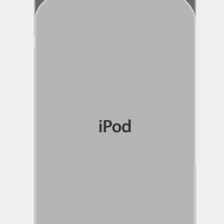

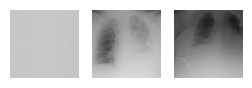

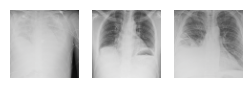

--


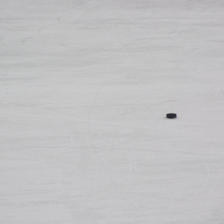

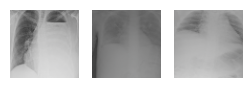

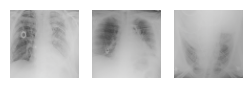

--


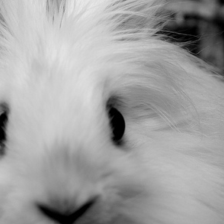

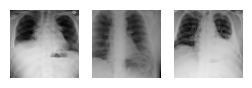

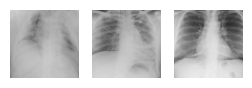

--


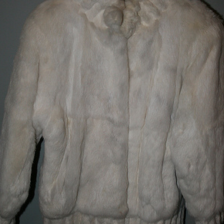

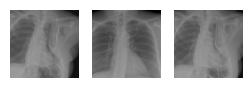

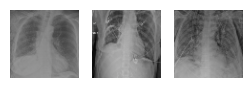

--


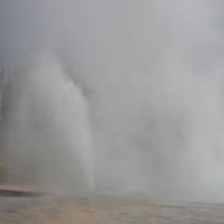

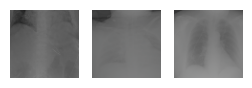

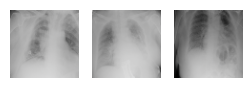

--


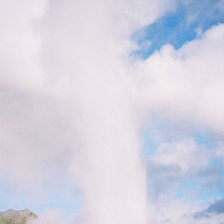

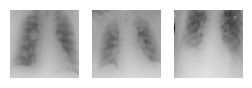

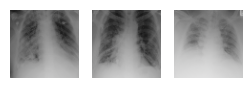

--


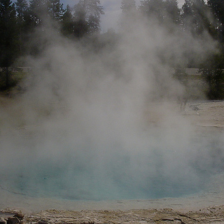

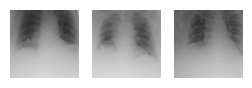

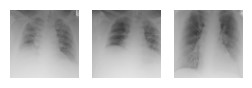

--


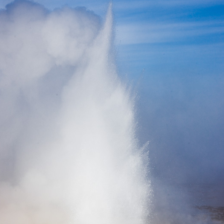

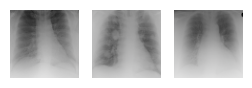

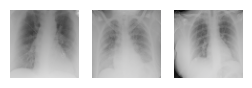

--


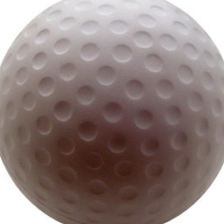

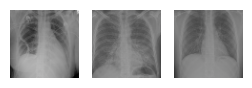

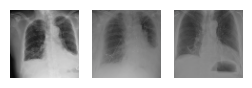

--


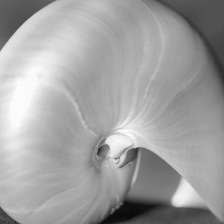

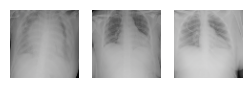

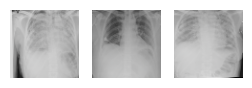

--


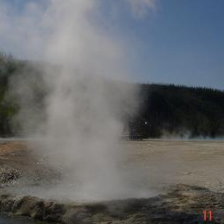

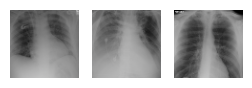

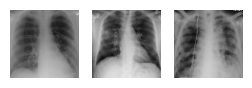

--


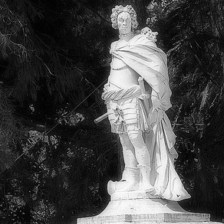

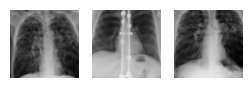

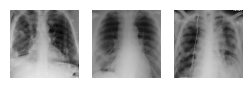

--


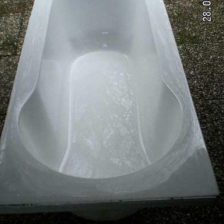

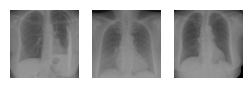

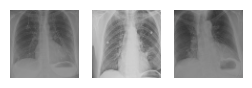

--


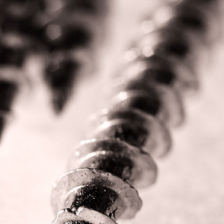

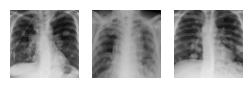

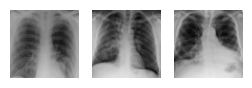

--


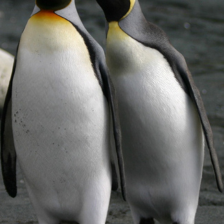

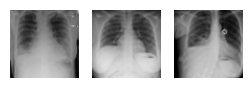

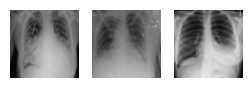

--


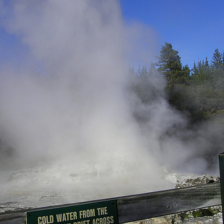

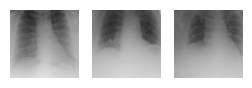

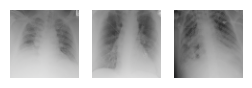

--


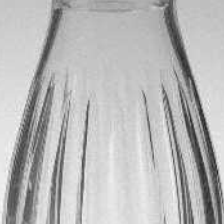

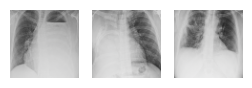

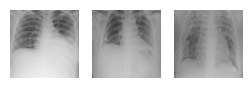

--


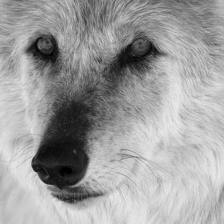

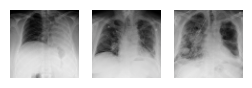

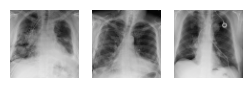

--


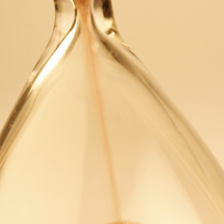

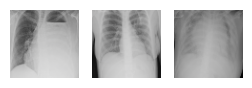

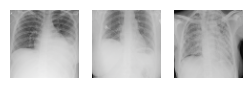

--


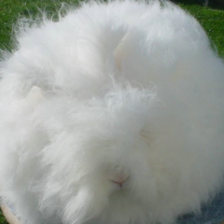

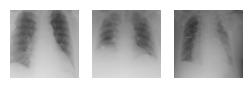

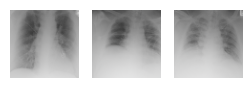

--


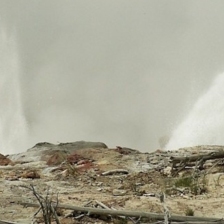

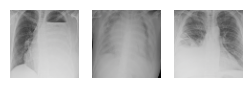

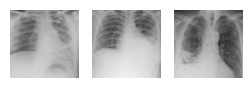

--


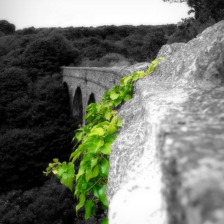

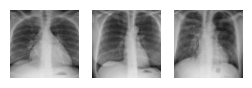

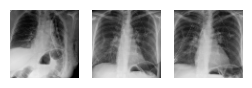

--


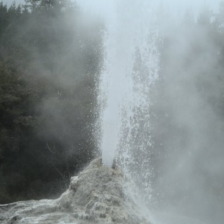

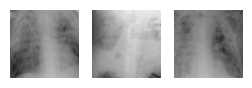

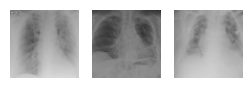

--


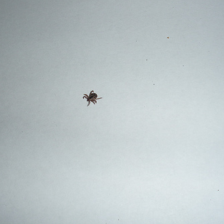

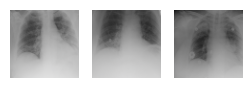

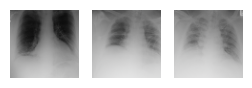

--


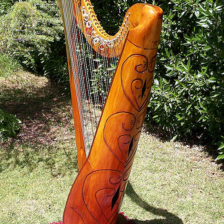

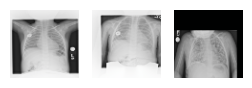

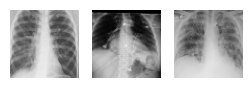

--


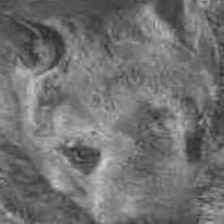

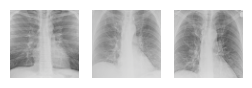

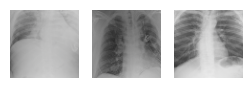

--


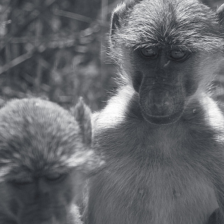

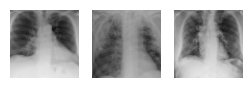

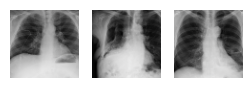

--


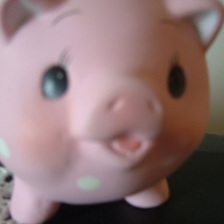

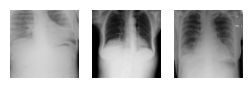

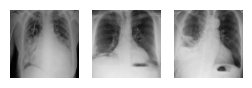

--


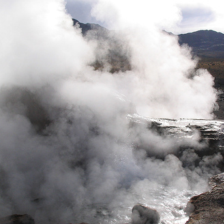

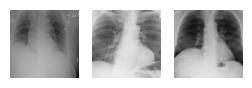

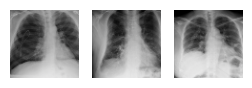

--


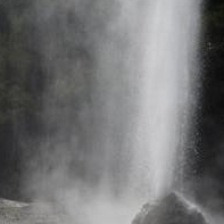

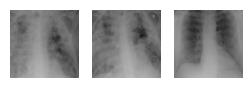

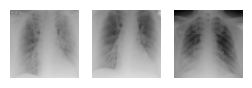

--


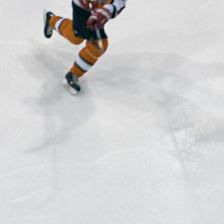

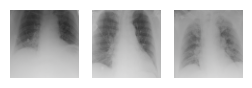

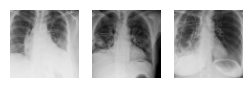

--


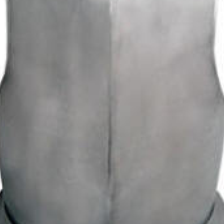

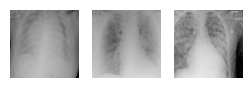

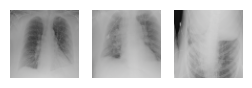

--


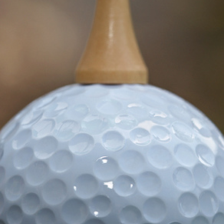

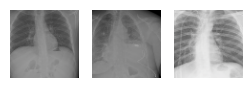

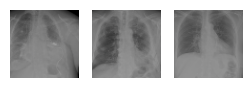

--


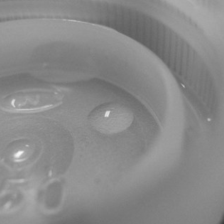

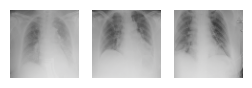

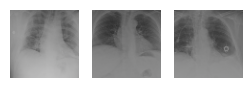

--


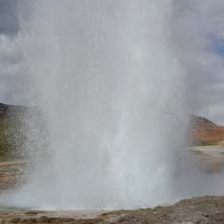

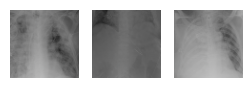

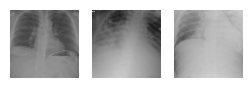

--


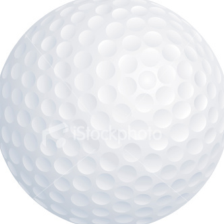

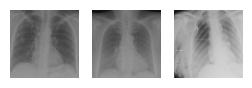

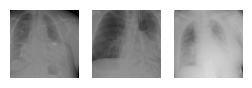

--


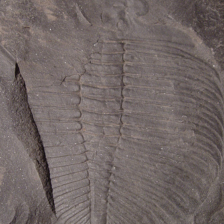

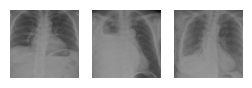

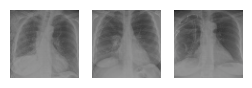

--


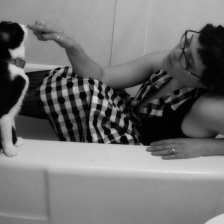

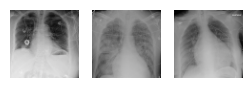

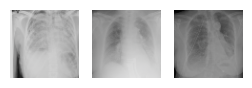

--


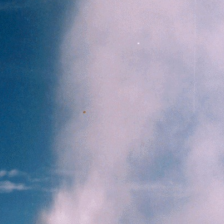

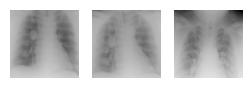

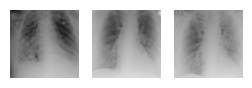

--


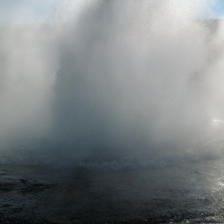

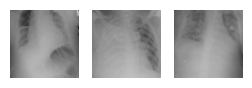

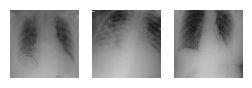

--


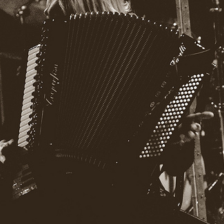

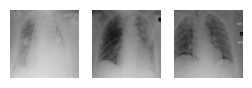

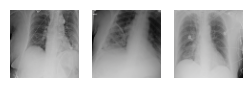

--


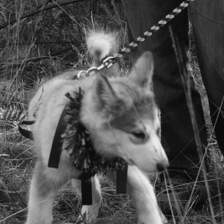

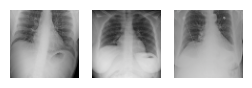

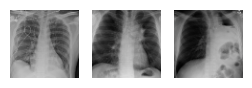

--


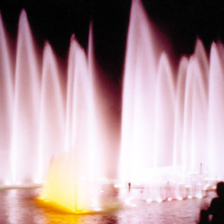

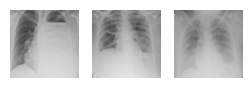

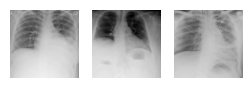

--


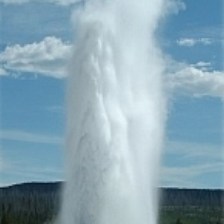

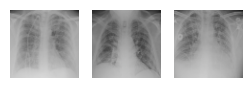

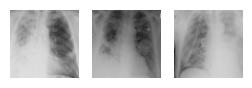

--


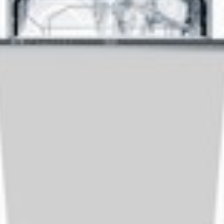

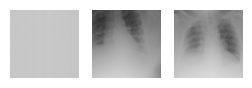

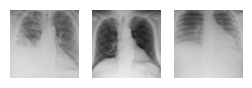

--


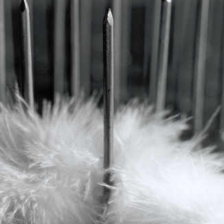

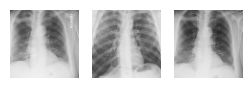

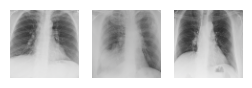

--


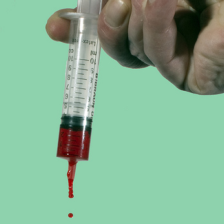

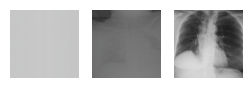

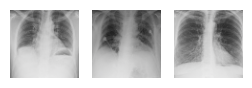

--


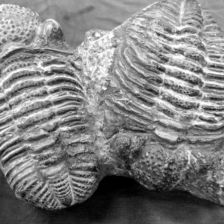

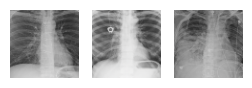

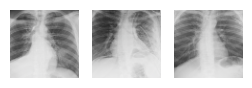

--


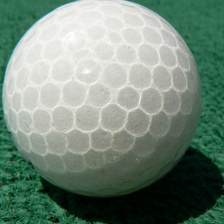

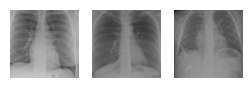

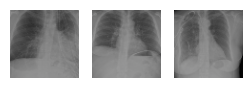

--


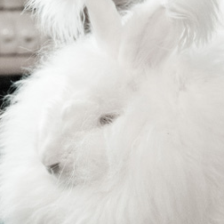

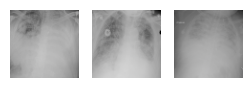

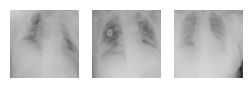

--


In [12]:
for train_index in torch.argsort(-infls.max(dim=1).values)[:50].cpu().numpy():
    display_infls(train_index)

In [11]:
infls = infls.cpu()

In [13]:
all_vals

tensor([0, 0, 0,  ..., 1, 1, 0])

In [12]:
infls[:, all_vals == 0].shape

torch.Size([1281167, 21344])

In [29]:
order = torch.argsort(infls[:, all_vals == 0].mean() + infls[:, all_vals == 1].mean())

OutOfMemoryError: CUDA out of memory. Tried to allocate 50.94 GiB (GPU 0; 79.15 GiB total capacity; 53.79 GiB already allocated; 24.82 GiB free; 53.82 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [15]:
infls[:, all_vals == 0].shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 50.94 GiB (GPU 0; 79.15 GiB total capacity; 53.79 GiB already allocated; 24.82 GiB free; 53.82 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [16]:
infls

OutOfMemoryError: CUDA out of memory. Tried to allocate 107.07 GiB (GPU 0; 79.15 GiB total capacity; 53.79 GiB already allocated; 24.82 GiB free; 53.82 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF